In [1]:
import time
import os
import sys
import numpy as np

#import ipympl
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')

import matplotlib.pyplot as plt

import astropy.units as u
from astropy import stats
from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import *
from mmtwfs.telescope import MMT

from pathlib import Path
from astropy.modeling import models, fitting

%load_ext autoreload
%autoreload 2

from scipy import optimize

In [2]:
plt.close('all')
home = Path(os.environ['HOME'])
mmirs = WFSFactory(wfs="mmirs", nzern=21)
f9wfs = WFSFactory(wfs="newf9", nzern=21)
f5wfs = WFSFactory(wfs="f5", nzern=21)

/Users/tim/conda/envs/py36/lib/python3.6/site-packages/photutils/detection/findstars.py:274: RuntimeWarning: overflow encountered in ulong_scalars
  sum2 = -quad1.sum() + quad2.sum() - quad3.sum() + quad4.sum()


<IPython.core.display.Javascript object>


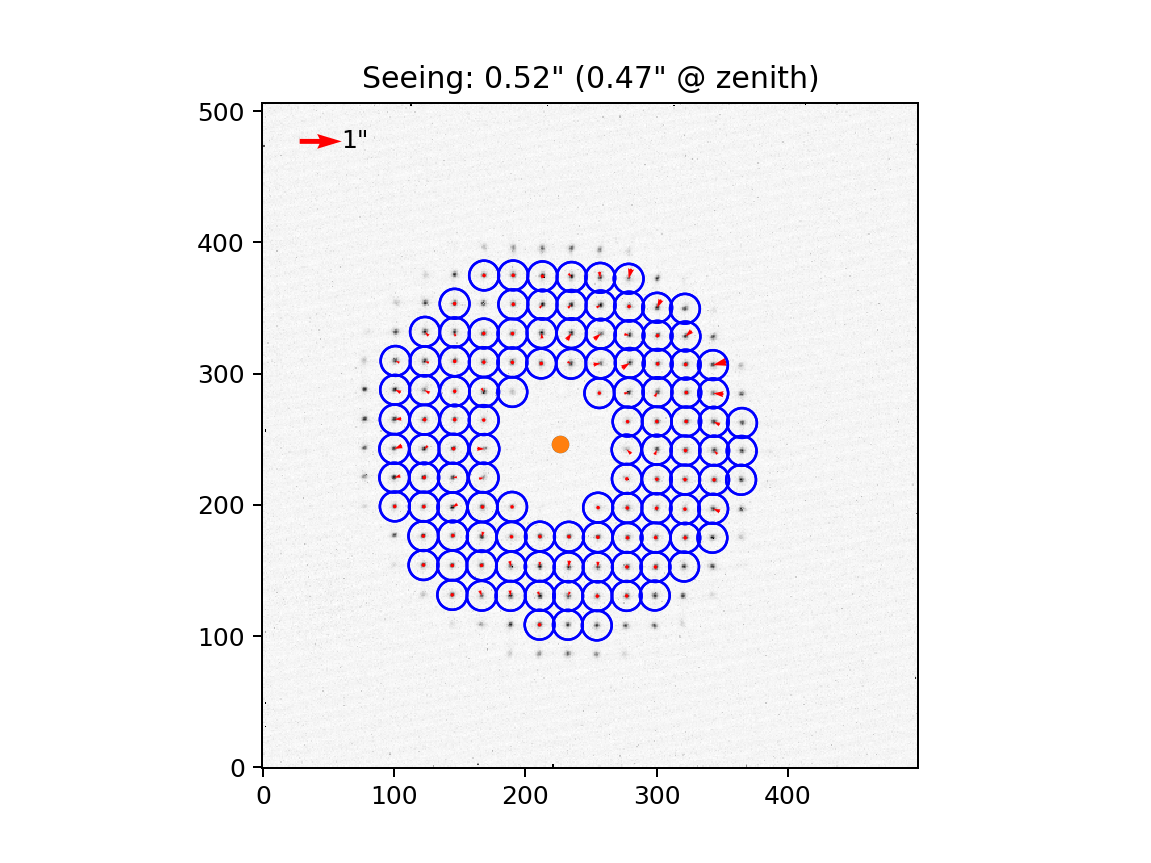

In [3]:
mmirs_file = home / "MMT/mmtwfs/mmtwfs/data/test_data/mmirs_wfs_0150.fits"
mmirs_results = mmirs.measure_slopes(mmirs_file, plot=True)
mmirs_results['figures']['slopes'].show()

<IPython.core.display.Javascript object>


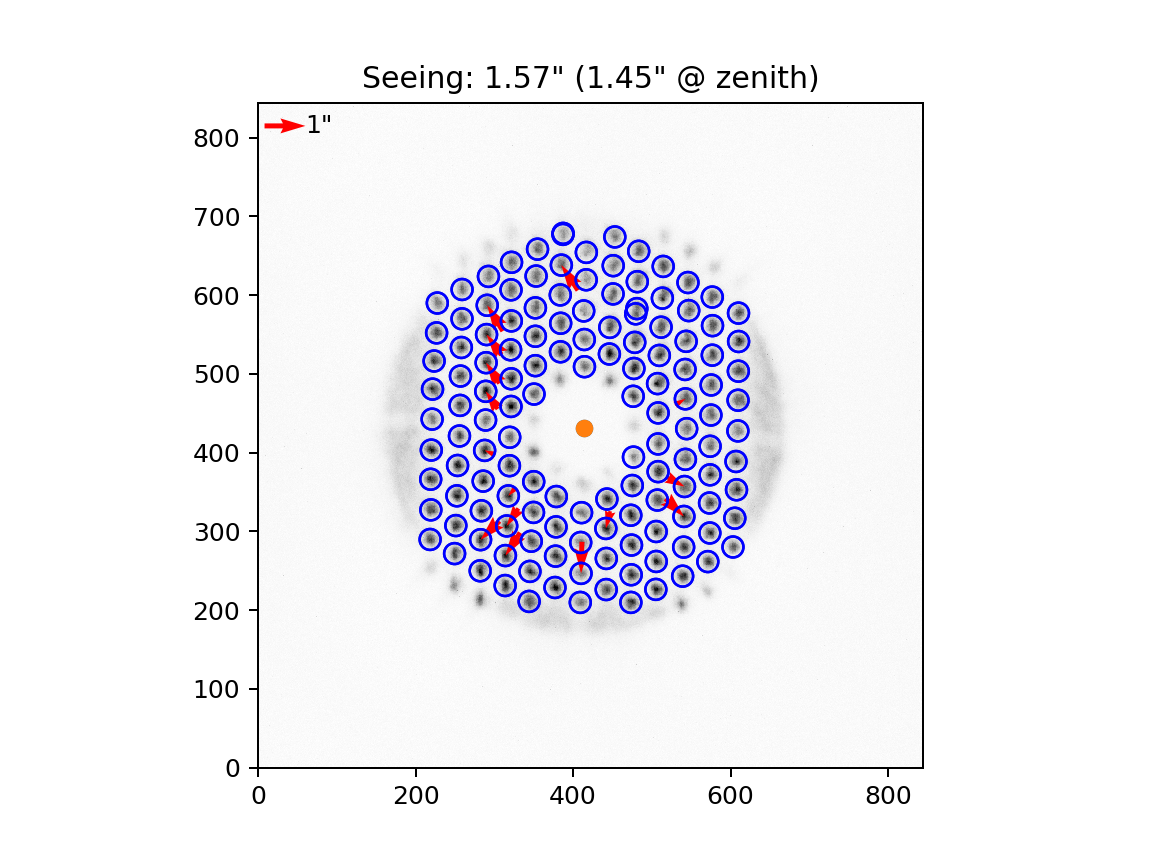

In [4]:
f9_file = home / "MMT/mmtwfs/mmtwfs/data/test_data/test_newf9.fits"
f9_results = f9wfs.measure_slopes(f9_file, 'blue', plot=True)
f9_results['figures']['slopes'].show()

<IPython.core.display.Javascript object>


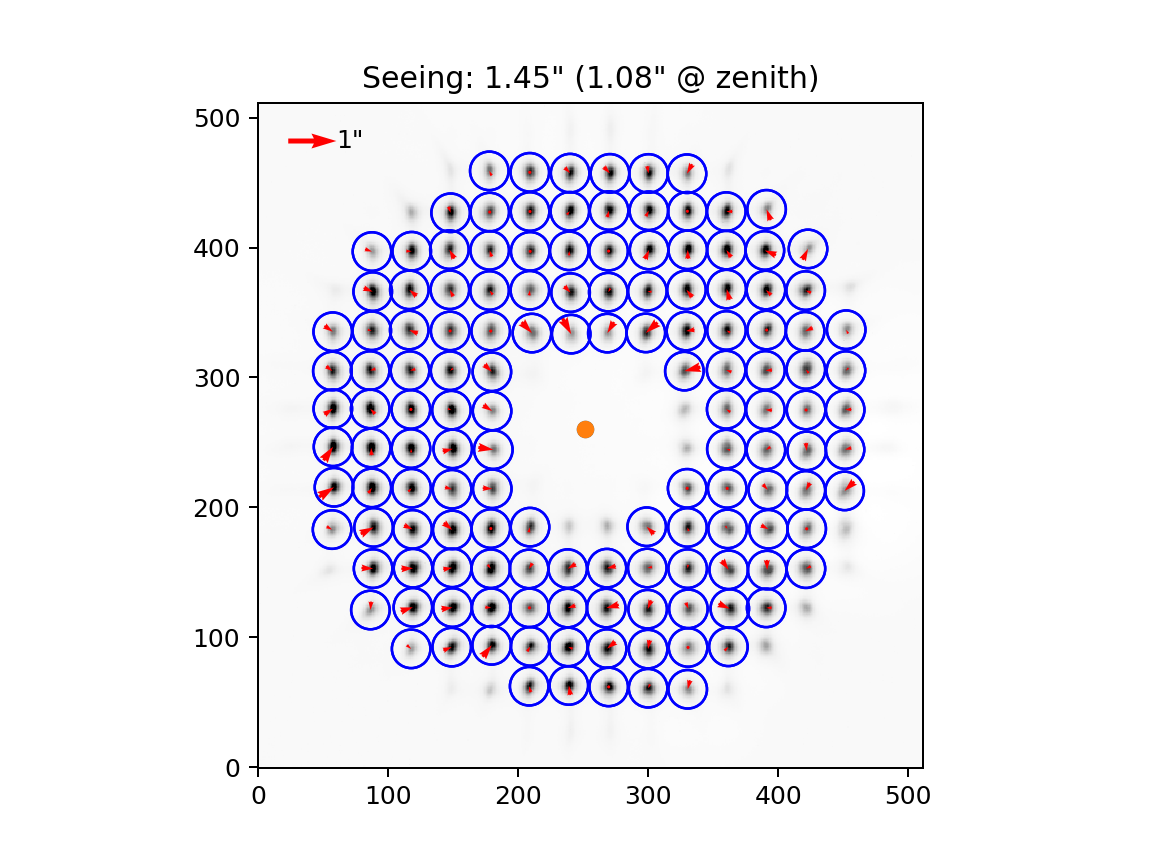

In [5]:
f5_file = home / "MMT/mmtwfs/mmtwfs/data/test_data/auto_wfs_0037_ave.fits"
f5_results = f5wfs.measure_slopes(f5_file, 'hecto', plot=True)
f5_results['figures']['slopes'].show()

In [6]:
def ZernikeGrad(Z, x, y, atype):

    if(len(Z) > 21):
        print('ZernikeGrad() is not implemented with >21 terms')
        return
    elif len(Z) < 21:
        Z = np.hstack((Z, np.zeros(22 - len(Z))))

    x2 = x * x
    y2 = y * y
    xy = x * y
    r2 = x2 + y2

    if (atype == 'dx'):
        d = 0. * x  # to make d an array with the same size as x
        d = d + Z[0] * 1.
        d = d + Z[1] * 0.
        d = d + Z[2] * 4. * x
        d = d + Z[3] * 2. * y
        d = d + Z[4] * 2. * x
        d = d + Z[5] * 6. * xy
        d = d + Z[6] * (9. * x2 + 3. * y2 - 2.)
        d = d + Z[7] * 6. * xy
        d = d + Z[8] * (3. * x2 - 3. * y2)
        d = d + Z[9] * 12. * x * (2. * (x2 + y2) - 1.)
        d = d + Z[10] * x * (16. * x2 - 6.)
        d = d + Z[11] * y * (24. * x2 + 8. * y2 - 6.)
        d = d + Z[12] * 4. * x * (x2 - 3. * y2)
        d = d + Z[13] * 4. * y * (3. * x2 - y2)
        d = d + Z[14] * (x2 * (50. * x2 + 60. * y2 - 36.) + y2 * (10. * y2 - 12.) + 3.)
        d = d + Z[15] * (xy * (40. * r2 - 24.))
        d = d + Z[16] * (x2 * (25. * x2 - 12. - 30. * y2) + y2 * (12. - 15. * y2))
        d = d + Z[17] * (4. * xy * (-6. + 15. * x2 + 5. * y2))
        d = d + Z[18] * 5. * (x2 * (x2 - 6. * y2) + y2 * y2)
        d = d + Z[19] * 20. * xy * (x2 - y2)
        d = d + Z[20] * 24. * x * (1. + x2 * (10. * y2 - 5. + 5. * x2) + y2 * (5. * y2 - 5.))

    elif (atype, 'dy'):

        d = 0. * y
        d = d + Z[0] * 0.
        d = d + Z[1] * 1.
        d = d + Z[2] * 4. * y
        d = d + Z[3] * 2. * x
        d = d + Z[4] * (-2.) * y
        d = d + Z[5] * (3. * x2 + 9. * y2 - 2.)
        d = d + Z[6] * 6. * xy
        d = d + Z[7] * (3. * x2 - 3. * y2)
        d = d + Z[8] * (-6.) * xy
        d = d + Z[9] * 12. * y * (2. * (x2 + y2) - 1.)
        d = d + Z[10] * y * (6. - 16. * y2)
        d = d + Z[11] * x * (8. * x2 + 24. * y2 - 6.)
        d = d + Z[12] * 4. * y * (y2 - 3. * x2)
        d = d + Z[13] * 4. * x * (x2 - 3. * y2)
        d = d + Z[14] * (xy * (40. * r2 - 24.))
        d = d + Z[15] * (x2 * (10. * x2 + 60. * y2 - 12.) + y2 * (50. * y2 - 36.) + 3.)
        d = d + Z[16] * (4. * xy * (6. - 5. * x2 - 15. * y2))
        d = d + Z[17] * (y2 * (-25. * y2 + 12. + 30. * x2) + x2 * (-12. + 15. * x2))
        d = d + Z[18] * 20. * xy * (y2 - x2)
        d = d + Z[19] * 5. * (x2 * (x2 - 6. * y2) + y2 * y2)
        d = d + Z[20] * 24. * y * (1. + y2 * (10. * x2 - 5. + 5. * y2) + x2 * (5. * x2 - 5.))

    return d

In [7]:
noll_coefficient(22)

2.6457513110645907

In [8]:
np.sqrt(7)

2.6457513110645907

In [9]:
def slope_chisq(zvec, coords, slopes, weights=1.0):
    x = coords[0]
    y = coords[1]
    xslope = slopes[0]
    yslope = slopes[1]
    pred_xslope = ZernikeGrad(zvec, x, y, atype='dx')
    pred_yslope = ZernikeGrad(zvec, x, y, atype='dy')
    d_sq = (xslope - pred_xslope)**2 + (yslope - pred_yslope)**2
    d_sq /= weights
    chisq = d_sq.sum()
    return chisq

In [10]:
slopes = -f5wfs.tiltfactor * f5_results['slopes']
pup_coords = f5wfs.modes['hecto']['reference'].pup_coords(f5wfs.pup_size/2.)

In [11]:
zfit = np.zeros(21)
results = optimize.minimize(slope_chisq, zfit, args=(pup_coords, slopes), method='BFGS')

In [12]:
results['x']

array([  215.68133402,   248.54151117, -2570.6835638 ,   170.86745642,
         676.5392472 ,  -170.92867927,  -221.62684558,   -46.22910982,
         174.22713105,  -355.53975909,  -102.72489244,    57.06477879,
         179.90051903,   219.53234074,    15.69560548,   121.33244574,
           5.20767306,    -6.90385413,    83.91799704,    -9.81942324,
         158.93613593])

In [13]:
z = ZernikeVector()
z.from_array(results['x'], modestart=2)
z

Fringe Coefficients
 Z02:       216 nm 	 X Tilt (1, 1)
 Z03:       249 nm 	 Y Tilt (1, -1)
 Z04: -2.57e+03 nm 	 Defocus (2, 0)
 Z05:       171 nm 	 Primary Astig at 45° (2, -2)
 Z06:       677 nm 	 Primary Astig at 0° (2, 2)
 Z07:      -171 nm 	 Primary Y Coma (3, -1)
 Z08:      -222 nm 	 Primary X Coma (3, 1)
 Z09:     -46.2 nm 	 Y Trefoil (3, -3)
 Z10:       174 nm 	 X Trefoil (3, 3)
 Z11:      -356 nm 	 Primary Spherical (4, 0)
 Z12:      -103 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:      57.1 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:       180 nm 	 X Tetrafoil (4, 4)
 Z15:       220 nm 	 Y Tetrafoil (4, -4)
 Z16:      15.7 nm 	 Secondary X Coma (5, 1)
 Z17:       121 nm 	 Secondary Y Coma (5, -1)
 Z18:      5.21 nm 	 Secondary X Trefoil (5, 3)
 Z19:      -6.9 nm 	 Secondary Y Trefoil (5, -3)
 Z20:      83.9 nm 	 X Pentafoil (5, 5)
 Z21:     -9.82 nm 	 Y Pentafoil (5, -5)
 Z22:       159 nm 	 Secondary Spherical (6, 0)

Total RMS: 	 	 1.53e+03 nm

351.08622979498347 nm
Fringe Coefficients
 Z02:      57.6 nm 	 X Tilt (1, 1)
 Z03:     -87.9 nm 	 Y Tilt (1, -1)
 Z04: -2.47e+03 nm 	 Defocus (2, 0)
 Z05:       122 nm 	 Primary Astig at 45° (2, -2)
 Z06:       569 nm 	 Primary Astig at 0° (2, 2)
 Z07:      -102 nm 	 Primary Y Coma (3, -1)
 Z08:      -144 nm 	 Primary X Coma (3, 1)
 Z09:     -50.3 nm 	 Y Trefoil (3, -3)
 Z10:       117 nm 	 X Trefoil (3, 3)
 Z11:      -373 nm 	 Primary Spherical (4, 0)
 Z12:      -104 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:      -103 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:      40.9 nm 	 X Tetrafoil (4, 4)
 Z15:       102 nm 	 Y Tetrafoil (4, -4)
 Z16:       153 nm 	 Secondary X Coma (5, 1)
 Z17:      8.57 nm 	 Secondary Y Coma (5, -1)
 Z18:      33.9 nm 	 Secondary X Trefoil (5, 3)
 Z19:       -70 nm 	 Secondary Y Trefoil (5, -3)
 Z20:     -47.7 nm 	 X Pentafoil (5, 5)
 Z21:       4.1 nm 	 Y Pentafoil (5, -5)
 Z22:       380 nm 	 Secondary Spherical (6, 0)

Total RMS: 	 	 1.47e+03 nm



<IPython.core.display.Javascript object>


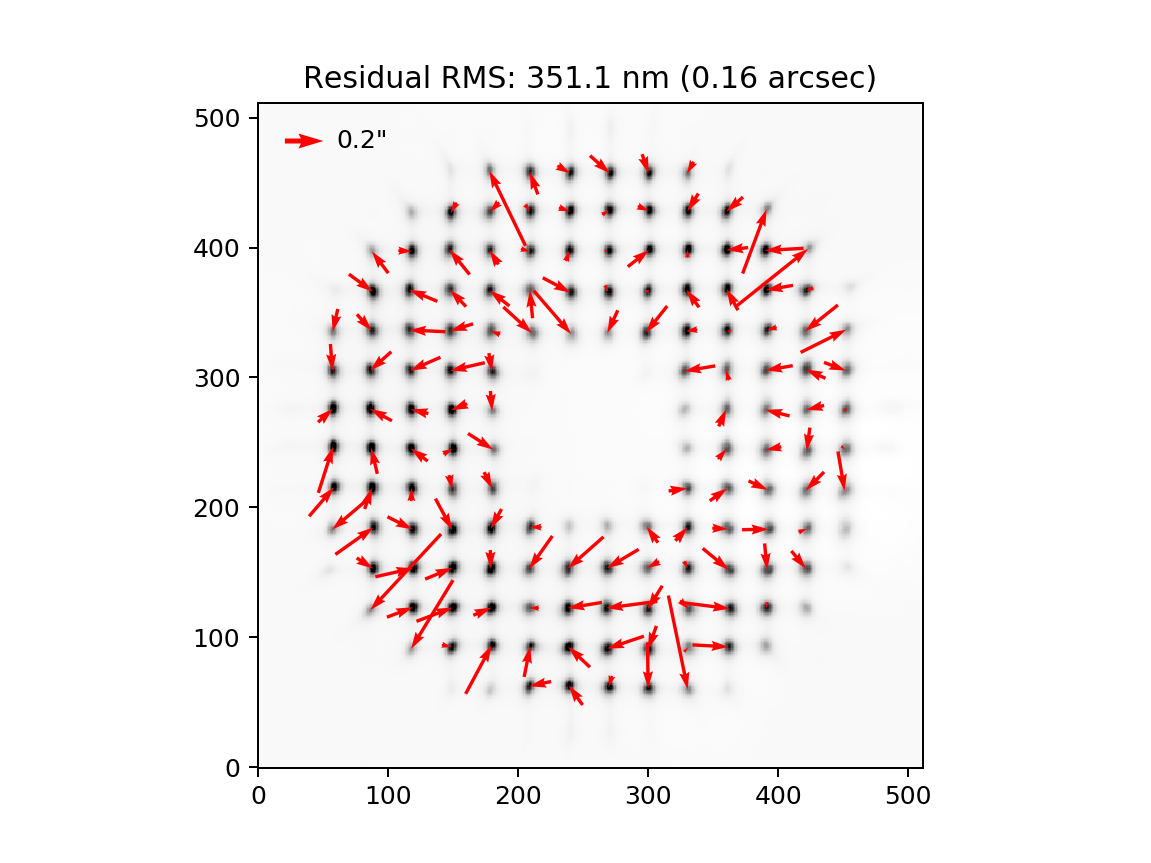

In [14]:
zresults = f5wfs.fit_wavefront(f5_results, plot=True)
print(zresults['residual_rms'])
print(zresults['raw_zernike'].pretty_print())
zresults['resid_plot'].show()

In [26]:
testdata, hdr = check_wfsdata("/Users/tim/mmirs_wfs_0120.fits", header=True)

In [27]:
mmirs.reference_aberrations('mmirs1', hdr=hdr)

Fringe Coefficients
 Z04: -1.61e+03 nm 	 Defocus (2, 0)
 Z05:      -226 nm 	 Primary Astig at 45° (2, -2)
 Z06:      -412 nm 	 Primary Astig at 0° (2, 2)
 Z07:     -11.4 nm 	 Primary Y Coma (3, -1)
 Z08:     -44.6 nm 	 Primary X Coma (3, 1)
 Z09:      81.1 nm 	 Y Trefoil (3, -3)
 Z10:      86.7 nm 	 X Trefoil (3, 3)
 Z11:      7.73 nm 	 Primary Spherical (4, 0)

Total RMS: 	 	 949 nm

In [29]:
610/40.8

14.950980392156863

In [23]:
np.sqrt((415/3)**2 + (1528/3)**2)

527.78457305566974

In [24]:
np.sqrt(67**2 + 7**2)

67.36467917239716

In [25]:
mmirs.focal_plane_position(hdr)

(<Quantity 0.08840606511527566 deg>, <Quantity 2.409156010043917 rad>)

In [37]:
zvec = mmirs.reference_aberrations('mmirs1', hdr=hdr)
zvec

Fringe Coefficients
 Z04: -1.61e+03 nm 	 Defocus (2, 0)
 Z05:      -226 nm 	 Primary Astig at 45° (2, -2)
 Z06:      -412 nm 	 Primary Astig at 0° (2, 2)
 Z07:     -11.4 nm 	 Primary Y Coma (3, -1)
 Z08:     -44.6 nm 	 Primary X Coma (3, 1)
 Z09:      81.1 nm 	 Y Trefoil (3, -3)
 Z10:      86.7 nm 	 X Trefoil (3, 3)
 Z11:      7.73 nm 	 Primary Spherical (4, 0)

Total RMS: 	 	 949 nm

In [38]:
zvec.rotate(angle=-90*u.deg)
zvec

Fringe Coefficients
 Z04: -1.61e+03 nm 	 Defocus (2, 0)
 Z05:       226 nm 	 Primary Astig at 45° (2, -2)
 Z06:       412 nm 	 Primary Astig at 0° (2, 2)
 Z07:      44.6 nm 	 Primary Y Coma (3, -1)
 Z08:     -11.4 nm 	 Primary X Coma (3, 1)
 Z09:      86.7 nm 	 Y Trefoil (3, -3)
 Z10:     -81.1 nm 	 X Trefoil (3, 3)
 Z11:      7.73 nm 	 Primary Spherical (4, 0)

Total RMS: 	 	 949 nm